# DCGan 
Convolutional Layer 를 이용한 GAN 이미지 생성 모델

- 논문: https://arxiv.org/pdf/1511.06434.pdf
- 파이 토치 튜토리얼: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [2]:
import os
import random
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Random Seed 설정
seed_value = 0
random.seed(seed_value)          # python random 모듈 seed
torch.manual_seed(seed_value)  # pytorch random seed
np.random.seed(seed_value)     # numpy random seed

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


# 하이퍼파라미터 변수 정의

- **dataroot:** 학습데이터셋 저장 디렉토리 경로
- **workers:** `DataLoader`로 데이터를 로드하기 위한 쓰레드 개수.
- **batch_size:** 배치 크기. DCGAN **논문에서는 128**의 배치 크기를 사용.
- **image_size:** 훈련에 사용되는 이미지의 크기. 여기서는 64 X 64 사용.
- **nc:** 입력 이미지의 컬러 채널 수. 컬러일 경우 3.
- **nz:** Latent vector 의 길이. Fake 이미지를 만들때 입력할 데이터.
- **ngf:** 제너레이터의 레이어들을 통과한 특징 맵크기의 기본값으로 레이어 별로 이 값에 * N한 값을 out features로 설정.
- **ndf:** 판별기의 레이어들을 통과한 특징 맵크기의 기본값으로 레이어 별로 이 값에 * N한 값을 out features로 설정.
- **num_epochs:** Train 에폭 수입니다. 더 오래 훈련할수록 더 나은 결과를 얻을 수 있지만 시간도 훨씬 더 오래 걸린다.
- **lr:** 훈련에 대한 학습률. DCGAN 논문에서 0.0002를 사용.
- **beta1:** 아담 옵티마이저를 위한 베타1 하이퍼파라미터. 논문에서 0.5를 사용.
- **ngpu:** 사용 가능한 GPU 개수. 0이면 CPU 모드에서 실행되고 0보다 크면 해당 수의 GPU에서 실행된다.

In [4]:
# 하이퍼파라미터 변수 설정

# dataroot = r"코랩 local 경로"
dataroot = r'C:\Classes\deeplearning\datasets'
os.makedirs(dataroot, exist_ok=True)

workers = os.cpu_count() 
batch_size = 128
image_size = 64
nc = 3 
nz = 100
ngf = 64
ndf = 64
num_epochs = 10
lr = 0.0002
beta1 = 0.5

# 학습 데이터셋 - celeb-A face dataset
- 유명인사들의 얼굴 사진들
- torchvision의 built-in dataset으로 받을 수 있다.
    - https://pytorch.org/vision/stable/generated/torchvision.datasets.CelebA.html#torchvision.datasets.CelebA
- 다음 사이트에서도 다운로드 받을 수 있다.
    - http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
    - 다운 받은 뒤 압축을 풀면 디렉토리구조가 다음과 같다.
    - 이것을 ImageFolder 를 이용해 Dataset으로 구성할 수 있다.
    ```
      /path/to/celeba
         -> img_align_celeba
            -> 188242.jpg
            -> 173822.jpg
            -> 284702.jpg
            -> 537394.jpg
    ```


## Dataset, DataLoader 생성

In [ ]:
# 정수: 종횡비가 다를경우 긴쪽을 64 resize하고 짧은 쪽은 종횡비에 맞게 줄인다.
transforms.Resize(64) 

In [6]:
!pip install gdown

In [5]:
transform = transforms.Compose([
                                transforms.Resize(image_size),     
                                transforms.CenterCrop(image_size),# 가운데를 잘라내기 크기를 64 x 64
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) ])

dataset = datasets.CelebA(root=dataroot, split="all", target_type=["attr", "identity"], download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

but Gdown can't. Please check connections and permissions.

## 다운받은 일부 이미지 확인

- vutils.make_grid: https://pytorch.org/vision/main/generated/torchvision.utils.make_grid.html
- 여러 이미지 Tensor 를 하나로 합친 Tensor를 반환한다.
- Parameter 
    - **tensor (Tensor or list)**: 4D mini-batch Tensor (Batch, Channel, Height, Width) 또는 같은 크기의 이미지 리스트   
    - **nrow (int, optional):** 한 행에 표시될 이미지의 개수. 최종 그리드의 형태는 ( Batch / nrow, nrow )가 된다. (Default : 8)   
    - **padding (int, optional)**: 이미지 사이 간격 pdding (Default : 2)
    - **normalize (bool, optional)**: True 일 경우, image 를 0~1 값으로 변환. (value_range 파라미터의 min, max 값을 기준) (Default : False)   
    - **pad_value (float, optional)**: 패딩 되는 픽셀의 값 (Default : 0)   

In [ ]:
real_batch = next(iter(dataloader))  # X(이미지들), y(label들)

In [ ]:
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training Images")
# vutils.make_grid() # 이미지들을 하나의 행렬로 합쳐주는 함수.
plt.imshow(vutils.make_grid(real_batch[0][:64] 
                            , padding=2
                            , normalize=True).permute(1, 2, 0))
plt.show()

# 모델 정의
GAN 모델은 Generator와 Discriminator 두 개 모델을 정의한다.

## 모델을 구성하는 Layer의 파라미터 초기화
- DCGAN 논문에서 저자에서  모든 모델 가중치를 평균=0, 표준편차=0.02의 정규 분포에서 무작위로 초기화하도록 한다.   
- `weights_init()` 함수는 Random값으로 초기화된 모델을 입력으로 받아 위 기준을 충족하도록 모든 convolution, convolution-transpose 및 Batch Normalization 레이어의 파라미터들을 다시 초기화한다.

In [10]:
# "asdlkjfasldkf".__class__.__name__

In [7]:
l = nn.Conv2d(3, 10, 3) # 객체 생성
l.__class__.__name__  #객체.__class__ : class  type객체: 객체의 class정보를 담은 class

'Conv2d'

In [28]:
# nn.init.normal_(l.weight.data, 100, 10)

In [13]:
"alkdfsljksdf".find("안녕")

-1

In [18]:
tmp = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float32)
print(tmp)
nn.init.normal_(tmp, 0, 10)
print(tmp)

tensor([1., 2., 3., 4., 5.])
tensor([-16.2392,   8.2318,  13.9330,  -5.7815, -11.7039])


In [29]:
## 논문에 따라 레이어의 파라미터들을 초기화하는 함수.
# nn.init.normal_(텐서, 평균, 표준편차): 텐서를 평균, 표준편차를 따르는 정규분포의 난수들로 채운다.
# nn.init.constant_(텐서, value): 텐서를 value:float 으로 채운다.
def weights_init(m:"Layer"):
    
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:  # 이름에 Conv가 있으면 --> Convolution Layer라면.
        nn.init.normal_(m.weight.data, 0.0, 0.02) #파라미터 초기화 (평균 0, 표준편차 0.002의 정규분포 랜덤값)
    elif classname.find('BatchNorm') != -1: # BatchNormalization Layer라면
        nn.init.normal_(m.weight.data, 1.0, 0.02) #파라미터 초기화 (평균: 1, 표준편차 0.002  정규분포 랜덤값)
        nn.init.constant_(m.bias.data, 0)     # bias = 0 초기화

## Generator

- Generator는 **Latent space Vector(잠재공간벡터) 를 입력** 받아 training image와 동일한 형태(분포)의 **이미지를 생성** 한다.
    - Latent space Vector는 GAN의 입력데이터로 동일한 분포(보통 정규분포)의 random 값으로 구성된다. random 값이 어떻게 구성되느냐에 따라 다른 이미지가 생성된다.
- Generator는 Strided Transpose Convolution, Batch Normalization, ReLU 로 이어지는 layer block들로 구성된다.
    - **Strided Convolution** pooling layer를 사용하지 않고 stride를 이용해 size를 조정하는 것을 말함.
    - **Transpose Convolution** 은 Convolution을 역으로 계산한다. 보통 Upsampling에 사용된다.
- Generator의 최종 출력은 \[-1, 1\] 범위의 결과를 리턴한다. 그래서 출력 Layer의 activation 함수로 **tanh**를 사용한다.


![paper](https://pytorch.org/tutorials/_images/dcgan_generator.png)<br>
\[DCGAN paper의 Generactor 구조\]

> ### Transpose Convolution Layer 출력 size 공식
> - i: input 크기
> - k: kernel 크기
> - s: stride
> - p: padding
> 
>$$
r\_size = k + (i-1)\times{s} - 2\times{p}
$$

In [32]:
# 입력: 10 x 10, kernel: 3 x 3, stride: 1, padding: 0
3 + (10 - 1)*1 - 2*0

12

In [38]:
4 + (4-1)*2 - 2*1

8

In [36]:
ngf * 4

256

In [60]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # 입력 : (batch, 100, 1, 1)  h: 1, w: 1, channel: 100 
        # feature map의 size는 늘리고  (Transpose Convolution)
        #     channel은 줄이는 방향으로 진행.  (out_channels 를 줄여나간다.)
        self.main = nn.Sequential(
            #ConvTranspose2d: Transpose Convolution Layer
            nn.ConvTranspose2d(in_channels=nz, # 100
                               out_channels=ngf * 8, 
                               kernel_size=4, 
                               stride=1,
                               padding=0, 
                               bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()  # -1 ~ 1
            
        )

    def forward(self, input):
        return self.main(input)

Generator를 생성하고 `weights_init` 함수를 적용한다.

In [ ]:
# model.apply(함수)  # 모델을 구성하는 layer들의 함수에 전달

In [42]:
# Generator 생성
netG = Generator().to(device)
### 모델을 구성하는 Layer들의 파라미터들을 초기화.
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Discriminator

- Discriminator는 trainset의 진짜 이미지와 generator가 생성한 가짜 이미지를 분류하는 역할을 한다. 이미지를 입력받아 이진분류를 해서 진짜이미지 인지 여부의 확률값을 출력한다.
- 모델의 구조는 Strided Convolution layer, Batch normalization, LeakyReLU 로 구성된 layer block들을 통과한 뒤 sigmoid activation 함수를 통해 최종 확률값을 출력한다.
    - 논문에서 Activation 함수로 ReLU가 아닌 LeakyReLU를 사용한 것이 특징이다.
    - 논문에서는 down sampling을 max pooling 이 아니라 convolution layer의 stride를 이용해 줄여 나간다.
        - 이유는 pooling layer를 사용할 경우 convolution layer가 pooling 함수를 학습하게 되기 때문이라고 한다. (convolution layer가 입력의 특성을 찾는 것 뿐만 아니라 어떻게 max pooling에 적용해야 할지 까지 학습하게 된다.)
 
![discriminator](figures/gan/discriminator.png)

In [45]:
ndf

64

In [49]:
# (i_size - k_size + 2*padding)/stride + 1  # conv 연산 결과 size
(8-4+2)/2 + 1

4.0

In [50]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # 입력: 이미지 - (batch, 3, 64, 64)  # channel:3, h: 64, w:64
        ### Feature map 의 size 는 줄이고 (Conv의 stride와 padding을 이용해서 줄인다.)
        ###     channel은 늘린다. (ndf(64) * n n: [1,2,4,8])
        self.main = nn.Sequential(
            nn.Conv2d(
                in_channels=nc,   
                out_channels=ndf, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False),
            nn.LeakyReLU(0.2, inplace=True),  # f(x) = max(x, x*negative_slope)

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),  # 1 x 1 x 1
            nn.Sigmoid()  # output: 양성(진짜이미지)일 확률로 변환.
        )

    def forward(self, input):
        return self.main(input)

In [51]:
# Discriminator 생성
netD = Discriminator().to(device)
# 모델 파라미터들을 초기화
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# 학습
## Loss 함수와 Optimizers

- GAN 모델의 최종 출력은 Real image인지 여부이므로 이진분류 문제이다.
- Loss 함수는 Binary Cross Entropy loss (BCELoss) 함수를 사용.

In [ ]:
import torch

In [52]:
loss_fn = nn.BCELoss()  # 이진분류 loss : Binary crossentropy

# 학습도중 500step마다 생성자가 만든 이미지를 출력.
### 생성자에 입력할 Latent vector (입력값을 고정하기 위해서 미리 생성.)
fixed_noise = torch.randn(64, nz, 1, 1, device=device) 
# (64:batch, 100:channel, 1:h, 1:w) => 64장의 이미지를 생성.

# y에 사용할 label
real_label = 1.  # 진짜 image label
fake_label = 0.  # 가짜 image label

### optimizer
##### 판별자 optimizer
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, 
                                         betas=(beta1, 0.999))  # beta1: 0.5
                                        # (모멘텀계수:moment의 hp, 이동가중평균계수:rmsprop hp)
##### 생성자 optimizer
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

In [53]:
num_epochs

10

In [58]:
a = torch.tensor([[1,2,3],[10,20,30]])
a.fill_(1000)
a

tensor([[1000, 1000, 1000],
        [1000, 1000, 1000]])

In [ ]:
# 학습도중 Generator가 생성한 이미지들을 저장할 리스트. (500 step마다 한번씩 생성.)
img_list = [] 

# Generator/Discriminator 의 step별 loss 를 저장.
G_losses = []
D_losses = []

print("Starting Training Loop...")

s_all = time.time()  # 전체 학습시간 계산용
for epoch in range(num_epochs):
    
    s = time.time() # 한 step 학습시간 계산용.
    for i, data in enumerate(dataloader, 0):  # i: 로그출력할 시점 확인용. (50 step마다 loss출력)

        ####################################################################################
        # (1) Update Discriminator(판별자) network Training
        ###################################################################################
        # 파라미터 gradient 초기화.
        netD.zero_grad() 
        # batch에서 이미지만 조회 -> device로 옮기기.
        real_cpu = data[0].to(device)  # data: (X, y)
        # batch 값을 조회 -> 현재 step에서 사용할 이미지 개수 (64, 3, 64, 64)
        b_size = real_cpu.size(0)
        # label 생성 - label의 class: 1.0 (real_label변수값)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        ##### 진짜 이미지로 판별자를 학습
        # 판별자를 dataset에서 가져온 진짜 이미지로 추정 (Image - 1.0)
        output = netD(real_cpu).view(-1)  # [64, 1] => [64]
        # loss 계산
        errD_real = loss_fn(output, label)
        # 파라미터들의 gradient  계산 (오차역전파)
        errD_real.backward()

        # output: 정답이 1인 이미지에대한 판별자의 예측 결과.
        # output.mean()  # 전체(예측한 개수) 중에 1의(맞은것) 비율
        D_x = output.mean().item()  # 진짜 이미지 추론한 결과 중 맞은 것의 비율

        ###### 가짜 이미지로 판별자 학습
        # 생성자를 이용해 가짜 이미지 생성.
        noise = torch.randn(b_size, nz, 1, 1, device=device) # Latent vector 정의
        # 가짜이미지 생성 (X)
        fake = netG(noise)  # 100, 1, 1 -> 3, 64, 64
        # 정답(Y)의 label 생성 -> 0.0
        label.fill_(fake_label)  # Tensor.fill_(value) Tensor의 값을 value로 다 변경.

        ### 판별자에 fake 이미지를 넣어서 추론
        output = netD(fake.detach()).view(-1)
        ## loss 계산 
        errD_fake = loss_fn(output, label)
        ## gradient 계산. (real image gradient 계산 결과에 누적. weight.grad)
        errD_fake.backward()
        
        # 판별자가 fake image에 대해 추론한 틀린 것의 비율
        ### fake 이미지 추론: 정답-0,  output.mean(): 값이 1(틀린것)인 것의 비율
        D_G_z1 = output.mean().item()
        # 진짜와 가짜 이미지 추론 결과 loss
        errD = errD_real + errD_fake
        #  판별자 파라미터 업데이트.
        optimizerD.step()

        #######################################################
        # (2) Update Generator(생성자) network Training
        #######################################################
        ### 파라미터 gradient값 초기화 (weight.grad=0)
        netG.zero_grad()
        # label 생성 -> 1.0 (real_image)
        label.fill_(real_label) 
        ## 판별자 학습할 때 생성한 fake 이미지를 넣어서 진짜인지 가짜인지 판별.
        output = netD(fake).view(-1) 
        ### 추론결과: 1(진짜) 이면 생성자 입장에서는 맞은 것. (판별자를 속이는 것이 목적이므로.)
        ############ 정답 label: 1 로 설정함(위에서 설정).
        ### loss 계산.
        errG = loss_fn(output, label)
        ### gradient 계산.
        errG.backward()
        ### 맞은 것의 비율(생성자 입장에서.)
        D_G_z2 = output.mean().item()
        # 생성자 파라미터 업데이트.
        optimizerG.step()

        #[09/10][1450:/1583]	Loss_D: 0.4004	Loss_G: 2.1506	D(x): 0.7787	D(G(z)): 0.1108 / 0.1560
        if i % 50 == 0:
            print('[{:02d}/{}][{:04d}:/{}]\tLoss_D: {:.4f}\tLoss_G: {:.4f}\tD(x): {:.4f}\tD(G(z)): {:.4f} / {:.4f}'.format(
                epoch+1,       # 현 에폭 index
                num_epochs,  # 전체 epochs 수
                i,                  # 현재 step수 (현재 epoch기준)
                len(dataloader),# 전체 step수(현재 epoch기준)
                errD.item(),     # 판별자 Loss
                errG.item(),     # 생성자 Loss
                D_x,              # 판별자가 real image 추론한 결과 맞은 것의 비율.        
                D_G_z1,         # 판별자가 fake image 에 대해 추론한 결과 틀린 것의 비율
                D_G_z2          # 생성자가 판별자를 잘 속인 비율.
                                     ##(fake 이미지를 판별자가 real 이라고 추론한 비율.)
            ))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # 500 step당 한번 또는 마지막 epoch이고 마지막 step일 때 generator가 생성한 
        ## 이미지들을 저장. (Generator에는 동일한 Latent vector를 입력해서 학습이 어떻게 되고
        ##     있는지를 확인 할 수있도록 한다.)
        if (i % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()  # [64, 3, 64, 64]
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        
    e = time.time()
    print(f"{epoch+1} epoch 걸린시간: {e-s}초")
    
e_all = time.time()
print(f"총 걸린 시간: {e_all - s_all}초")

In [ ]:
### 학습결과 시각화
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
def show_fake_image(idx):
    """학습도중 저장한 fake 이미지를 출력"""
    plt.figure(figsize=(10,10))
    img = img_list[idx].permute(1,2,0)
    plt.imshow(img)
    plt.show()
    
show_fake_image(10)

In [ ]:
# Tain set의 이미지와 생성한 이미지 비교
# real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).permute(1,2,0))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## 코랩에서 학습한 생성자 loading 후 이미지 생성

In [61]:
import torch

load_generator = torch.load("saved_models/generator.pth", map_location=device)
load_generator

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [67]:
# Generator 입력 (Latent vector) : 표준정규분포를 따르는 랜덤값으로 구성. 
#                                           shape: (생성할이미지개수, 100, 1, 1)
lv = torch.randn(12, 100, 1, 1, device=device)
print(lv.shape)

torch.Size([12, 100, 1, 1])


In [68]:
# 이미지 생성
result = load_generator(lv)
## 생성한 이미지들을 하나로 합치기
images = vutils.make_grid(result, padding=2, nrow=3, normalize=True)

In [70]:
print(result.shape, images.shape)

torch.Size([12, 3, 64, 64]) torch.Size([3, 266, 200])


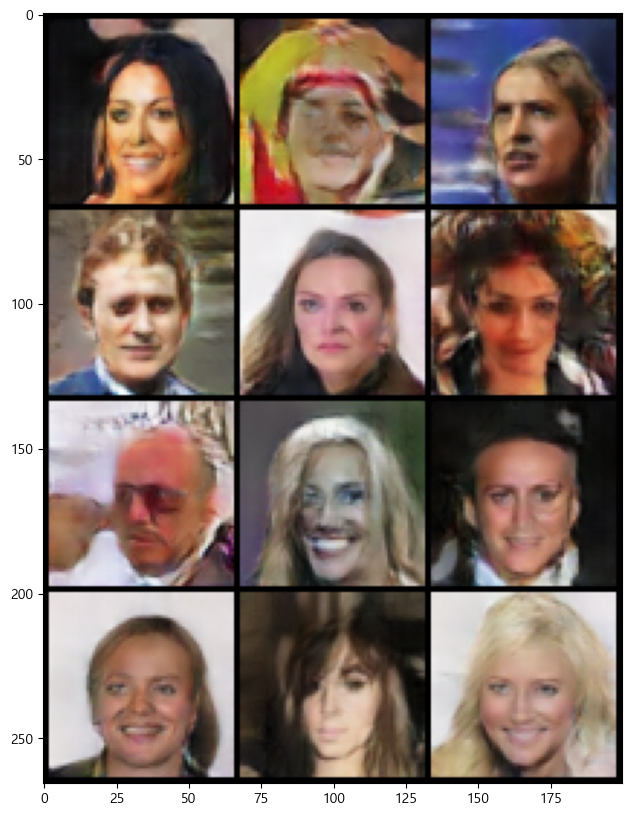

In [74]:
plt.figure(figsize=(12, 10))
plt.imshow(images.permute(1, 2, 0))
plt.show()